In [427]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
import os

# Change the working directory to one level higher
if not os.getcwd().endswith('tqs_unitaries'):
    os.chdir('..')

In [429]:
import matplotlib.pyplot as plt
import torch
import math
from typing import Optional, Tuple

In [430]:
# Load values saved from tqs_vs_exact.py
LOAD_PATH = "out/plain_ising/plain_vs_exact_size_16_eval_negated_h/tqs_vs_exact_ising_n16_param1.0000.pt"
data = torch.load(LOAD_PATH)
psi_tqs = data["psi_tqs"]
psi_exact = data["psi_exact"]
log_amp = data["log_amp"]
log_phase = data["log_phase"]
overlap = data["overlap"]

In [431]:
# Verify interpretation of log amp; exponentiated, they sum to 1.
log_amp.exp().sum()

tensor(1.0000)

In [432]:
prob = log_amp.exp()
phase = log_phase.clone()

In [433]:
# Ensure we can recover the same overlap from the script
torch.vdot(psi_exact, psi_tqs.to(dtype=torch.complex128)), overlap

(tensor(-0.7579-0.6274j, dtype=torch.complex128),
 tensor(-0.7579-0.6274j, dtype=torch.complex128))

In [434]:
def plot_wave_function_components(wave_function, title_prefix="Wave Function"):
    """
    Plots the real and imaginary components of a complex wave function tensor using vertical lines.

    Args:
        wave_function (torch.Tensor): A complex tensor representing the wave function.
        title_prefix (str): A prefix for the plot titles.
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    indices = range(len(wave_function))

    # Plot real part
    axs[0].vlines(indices, 0, wave_function.real.numpy(), label='Real Part', color='blue')
    axs[0].set_title(f'{title_prefix} - Real Part')
    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Value')
    axs[0].grid(True)
    axs[0].legend()

    # Plot imaginary part
    axs[1].vlines(indices, 0, wave_function.imag.numpy(), label='Imaginary Part', color='orange')
    axs[1].set_title(f'{title_prefix} - Imaginary Part')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [435]:
def plot_wrapped_wavefunction_2d(
    psi: torch.Tensor,
    system_size: int,
    *,
    split: Optional[Tuple[int, int]] = None,
    cmap: str = "plasma",
    figsize: Tuple[float, float] = (12, 5),
) -> None:
    """
    Reshape a complex many-body wavefunction into a 2D bipartitioned form
    and plot its real and imaginary parts as heatmaps.

    Parameters
    ----------
    psi : torch.Tensor
        Complex-valued tensor of shape (2**system_size,).
        Represents the wavefunction in the computational basis.
    system_size : int
        Number of spins/sites N.
    split : (int, int), optional
        Bipartition (nA, nB) with nA + nB = N.
        If None, uses equal split (N//2, N - N//2).
    cmap : str
        Matplotlib colormap. Default is "plasma" (yellow–purple).
    figsize : tuple
        Figure size.

    Returns
    -------
    None
        Displays the heatmaps.
    """

    if not torch.is_complex(psi):
        raise ValueError("psi must be a complex-valued tensor.")

    if psi.ndim != 1:
        raise ValueError("psi must be a 1D tensor of shape (2**N,).")

    expected_dim = 2 ** system_size
    if psi.numel() != expected_dim:
        raise ValueError(
            f"Wavefunction size {psi.numel()} does not match 2**{system_size} = {expected_dim}."
        )

    if split is None:
        nA = system_size // 2
        nB = system_size - nA
    else:
        nA, nB = split
        if nA + nB != system_size:
            raise ValueError("split must satisfy nA + nB = system_size.")

    dimA = 2 ** nA
    dimB = 2 ** nB

    # Reshape into bipartition matrix
    psi_matrix = psi.reshape(dimA, dimB)

    # Move to CPU and convert to numpy for plotting
    psi_np = psi_matrix.detach().cpu().numpy()

    real_part = psi_np.real
    imag_part = psi_np.imag

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    im0 = axes[0].imshow(real_part, cmap=cmap, aspect="auto")
    axes[0].set_title("Real part")
    axes[0].set_xlabel(f"Subsystem B (2^{nB})")
    axes[0].set_ylabel(f"Subsystem A (2^{nA})")
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(imag_part, cmap=cmap, aspect="auto")
    axes[1].set_title("Imaginary part")
    axes[1].set_xlabel(f"Subsystem B (2^{nB})")
    axes[1].set_ylabel(f"Subsystem A (2^{nA})")
    fig.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

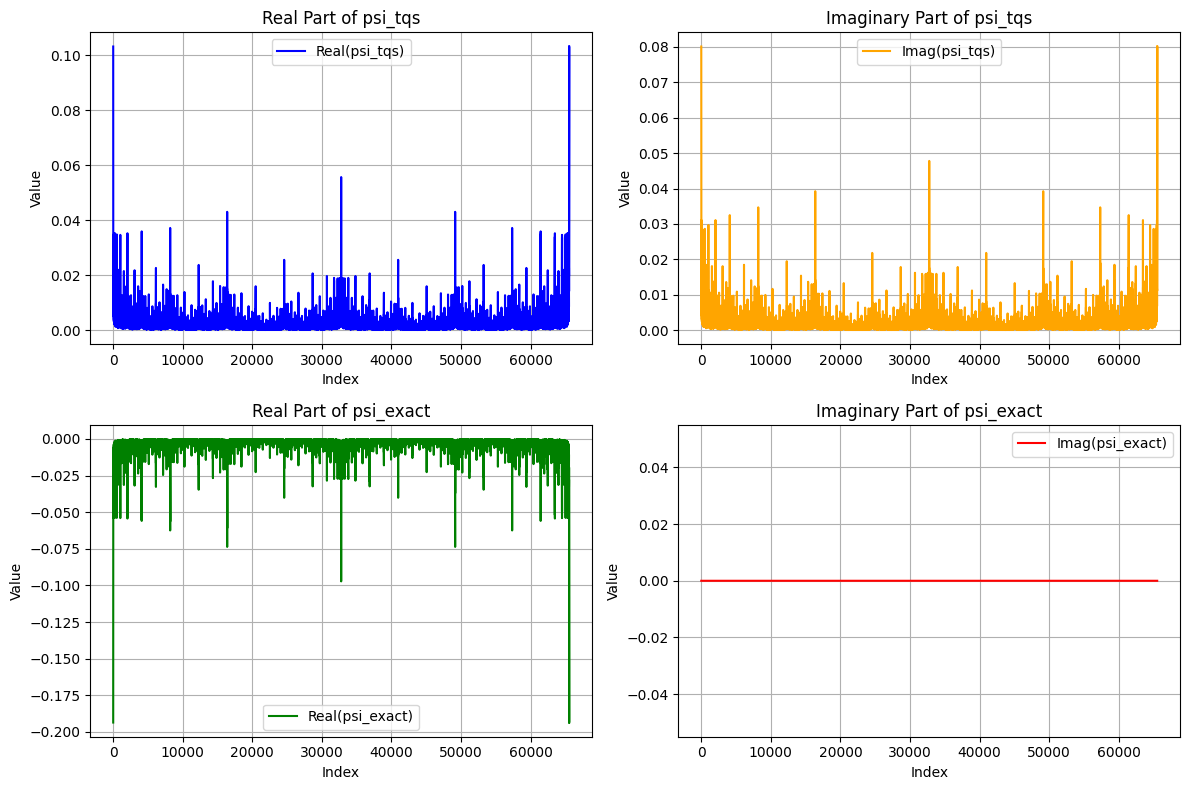

In [436]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot real part of psi_tqs
axs[0, 0].plot(psi_tqs.real.numpy(), label='Real(psi_tqs)', color='blue')
axs[0, 0].set_title('Real Part of psi_tqs')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Value')
axs[0, 0].grid(True)
axs[0, 0].legend()

# Plot imaginary part of psi_tqs
axs[0, 1].plot(psi_tqs.imag.numpy(), label='Imag(psi_tqs)', color='orange')
axs[0, 1].set_title('Imaginary Part of psi_tqs')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Value')
axs[0, 1].grid(True)
axs[0, 1].legend()

# Plot real part of psi_exact
axs[1, 0].plot(psi_exact.real.numpy(), label='Real(psi_exact)', color='green')
axs[1, 0].set_title('Real Part of psi_exact')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Value')
axs[1, 0].grid(True)
axs[1, 0].legend()

# Plot imaginary part of psi_exact
axs[1, 1].plot(psi_exact.imag.numpy(), label='Imag(psi_exact)', color='red')
axs[1, 1].set_title('Imaginary Part of psi_exact')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Value')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Recovering Phases

In [437]:
# Perform phase adjustments
phase -= phase.mean()
phase +=  torch.pi

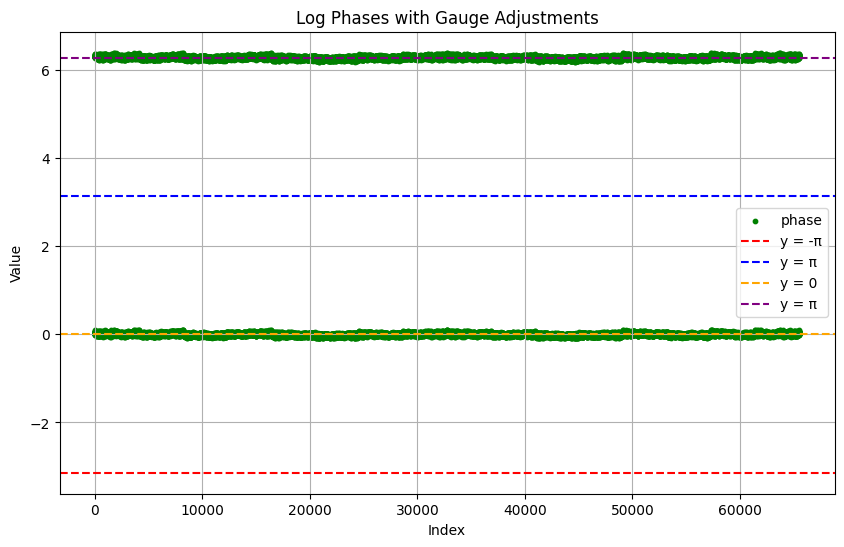

In [438]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(phase)), phase.numpy(), label='phase', color='green', s=10)
plt.axhline(y=-math.pi, color='red', linestyle='--', label='y = -π')
plt.axhline(y=math.pi, color='blue', linestyle='--', label='y = π')
plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
plt.axhline(y=2 * math.pi, color='purple', linestyle='--', label='y = π')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Log Phases with Gauge Adjustments')
plt.legend()
plt.grid(True)
plt.show()

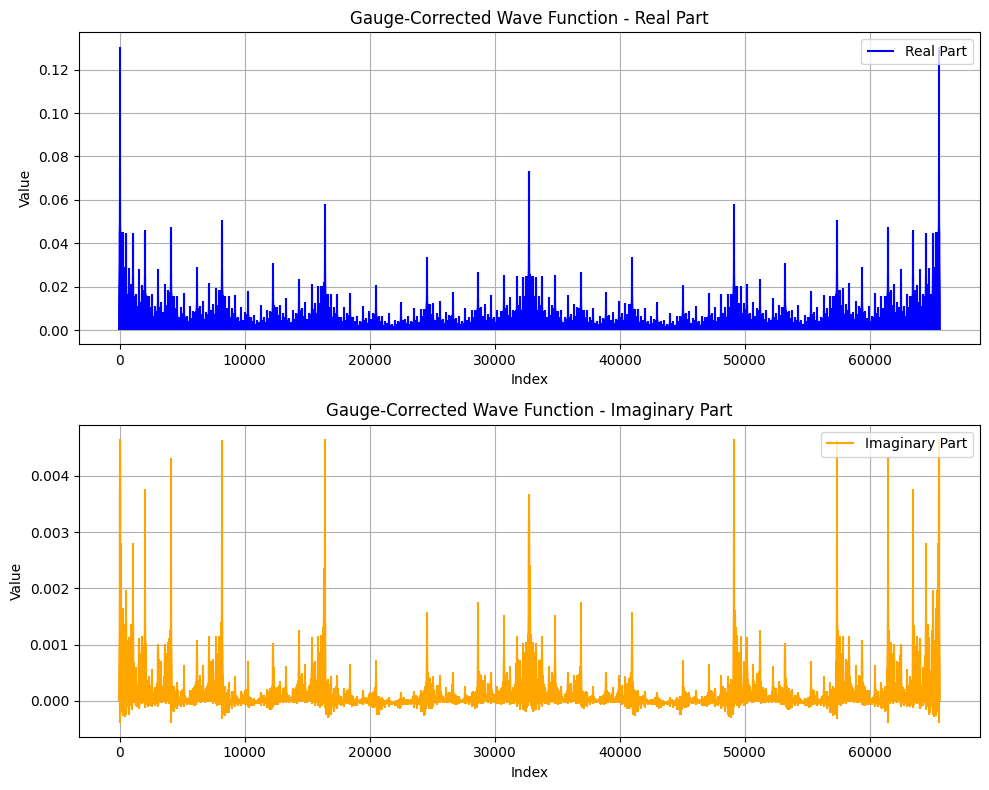

In [439]:
# Reconstruct wave function with gauge-corrected phases
psi_phase_adjusted = torch.sqrt(prob) * torch.exp(1j * phase)
plot_wave_function_components(psi_phase_adjusted, title_prefix="Gauge-Corrected Wave Function")

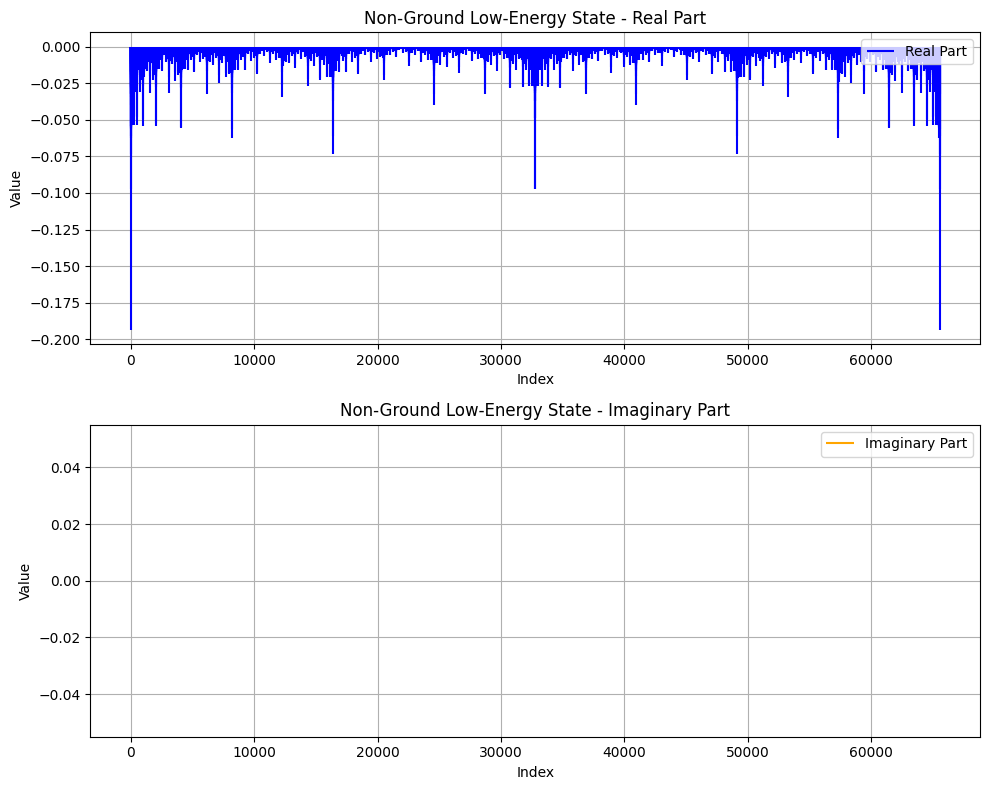

In [440]:
num_state = 0
nth_lowest_state = data["low_states"][:, num_state]
nth_lowest_energy = data["low_energies"][num_state]

plot_wave_function_components(nth_lowest_state, title_prefix="Non-Ground Low-Energy State")

In [441]:
(psi_phase_adjusted.conj() @ psi_phase_adjusted)

tensor(1.0000+0.j)